# Predicting molecular solubility using a deep learning algorithm

**Many thanks to the contributions of Patrick Walters and Chanin Nantasenamat who are great teachers in the field of chemoinformatics**

https://github.com/PatWalters/chem_tutorial

https://github.com/dataprofessor/code/blob/master/python/cheminformatics_predicting_solubility.ipynb

In [64]:
import pandas as pd #data table manipulation
import os
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors, NumRotatableBonds, HeavyAtomCount

from rdkit.Chem.Draw import IPythonConsole #RDKit drawing
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import Draw #RDKit drawing
# A few settings to improve the quality of structures 
from rdkit.Chem import rdDepictor
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import PandasTools #Add the ability to add a molecule to a dataframegrid
from rdkit import RDConfig
import mols2grid #The mols2grid library provides a convenient way of displaying molecules in a grid


import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # descision trees 
from sklearn.model_selection import train_test_split # split a dataset
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
from dtreeviz.trees import * #plotting decision trees
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, plot_roc_curve, plot_confusion_matrix # model stats

Enable Pandas **progress_apply**

In [3]:
tqdm.pandas()

Data taken from the following paper:

https://www.nature.com/articles/s41597-019-0151-1#rightslink

In [4]:
df2 = pd.read_csv("https://www.amdlab.nl/database/AqSolDB/data/AqSolDB_v1.0_min.csv")

In [5]:
df2

,ID,Name,InChIKey,SMILES,Solubility
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,A-4,Benzo[cd]indol-2(1H)-one,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767
2,A-5,4-chlorobenzaldehyde,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065
...,...,...,...,...,...
9977,I-84,tetracaine,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000
9978,I-85,tetracycline,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000
9979,I-86,thymol,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000
9980,I-93,verapamil,SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000


In [6]:
df2.rename(columns={"Solubility": "Log_Solubility"}, inplace=True)

Checking the sum of unknown values

In [7]:
df2.isna().sum()

ID                0
Name              0
InChIKey          0
SMILES            0
Log_Solubility    0
dtype: int64

Adding the molecular strcutrue to the dataframe, according to the SMILES

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df2,'SMILES','Structure',includeFingerprints=True)

,ID,Name,InChIKey,SMILES,Log_Solubility,Structure
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,
1,A-4,Benzo[cd]indol-2(1H)-one,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,
2,A-5,4-chlorobenzaldehyde,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,
...,...,...,...,...,...,...
9977,I-84,tetracaine,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,
9978,I-85,tetracycline,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,
9979,I-86,thymol,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,
9980,I-93,verapamil,SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,

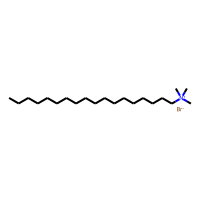
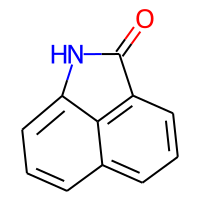
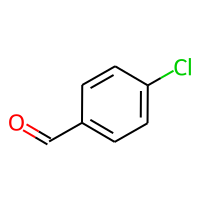
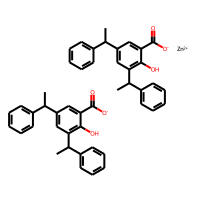
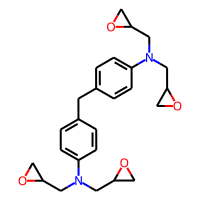
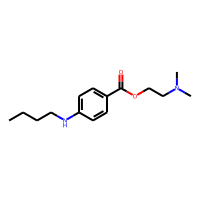
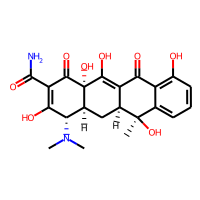
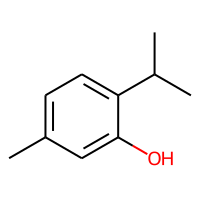
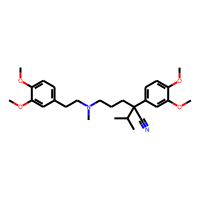
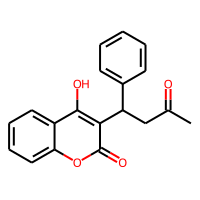

In [9]:
df2

### Adding molecular descriptors to the dataframe

A simple function to calculate molecular weight, LogP, number of aromatic rings, number of hydrogen bond donors and acceptors from a SMILES

Look up more descriptions:

https://chem-workflows.com/articles/2021/09/05/exploration-of-the-chemical-space-using-rdkit-and-cheminformatics/

In [10]:
def calc_descriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        mw, logp, num_arom_rings, hbd, hba, rot_bond, hev_atm = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors, NumRotatableBonds, HeavyAtomCount]]
        res = [mw, logp, num_arom_rings, hbd, hba, rot_bond, hev_atm]
    else:
        res = [None] * 5
    return res

In [11]:
# HBond_Donor','HBond_Acceptor','Rot_Bond', 'Hev_Atm'

In [12]:
df2.dtypes

ID                 object
Name               object
InChIKey           object
SMILES             object
Log_Solubility    float64
Structure          object
dtype: object

In [ ]:
df2['desc'] = df2.SMILES.progress_apply(calc_descriptors)

,ID,Name,InChIKey,SMILES,Log_Solubility,Structure,desc
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,,"[392.5100000000002, 3.9581000000000017, 0, 0, ..."
1,A-4,Benzo[cd]indol-2(1H)-one,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,,"[169.18299999999996, 2.405500000000001, 2, 1, ..."
2,A-5,4-chlorobenzaldehyde,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,,"[140.569, 2.1525, 1, 0, 1, 1, 9]"
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,,"[756.2260000000002, 8.11610000000001, 6, 2, 6,..."
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,,"[422.5250000000002, 2.4854000000000003, 2, 0, ..."
...,...,...,...,...,...,...,...
9977,I-84,tetracaine,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,,"[264.36899999999997, 2.617000000000001, 1, 1, ..."
9978,I-85,tetracycline,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,,"[444.44000000000017, -0.21439999999999926, 1, ..."
9979,I-86,thymol,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,,"[150.221, 2.8240200000000013, 1, 1, 1, 1, 11]"
9980,I-93,verapamil,SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,,"[454.6110000000002, 5.093080000000005, 2, 0, 6..."

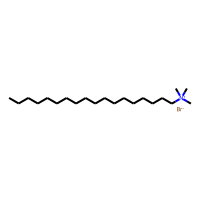
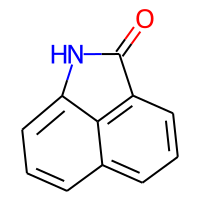
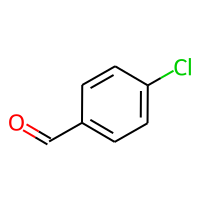
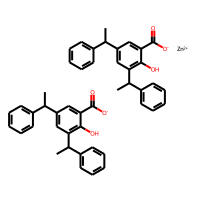
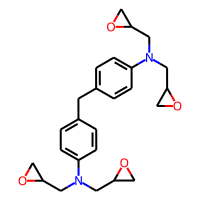
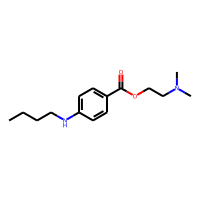
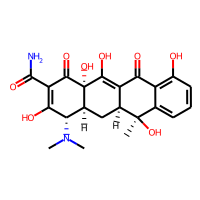
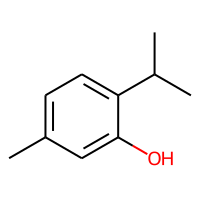
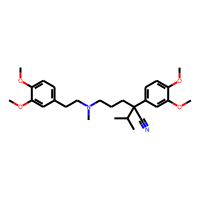
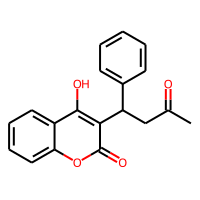

In [14]:
df2

,ID,Name,SMILES,Log_Solubility,Structure,MW,LogP,NumAromatic,HBond_Donor,HBond_Acceptor,Rot_Bond,Hev_Atm
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,,392.510,3.95810,0.0,0.0,0.0,17.0,23.0
1,A-4,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,,169.183,2.40550,2.0,1.0,1.0,0.0,13.0
2,A-5,4-chlorobenzaldehyde,Clc1ccc(C=O)cc1,-2.177078,,140.569,2.15250,1.0,0.0,1.0,1.0,9.0
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,,756.226,8.11610,6.0,2.0,6.0,10.0,53.0
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,,422.525,2.48540,2.0,0.0,6.0,12.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9977,I-84,tetracaine,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,,264.369,2.61700,1.0,1.0,4.0,8.0,19.0
9978,I-85,tetracycline,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,,444.440,-0.21440,1.0,6.0,9.0,2.0,32.0
9979,I-86,thymol,c1(cc(ccc1C(C)C)C)O,-2.190000,,150.221,2.82402,1.0,1.0,1.0,1.0,11.0
9980,I-93,verapamil,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,,454.611,5.09308,2.0,0.0,6.0,13.0,33.0

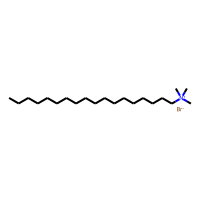
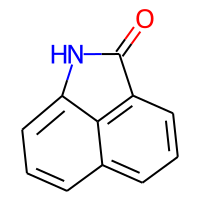
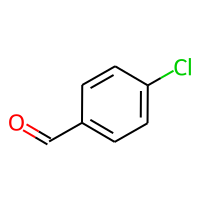
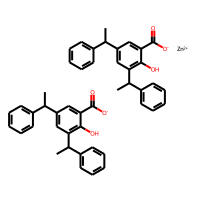
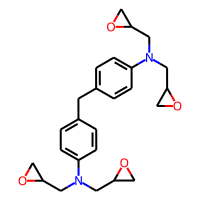
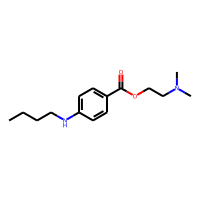
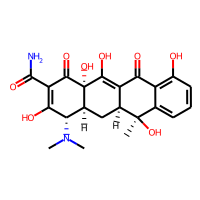
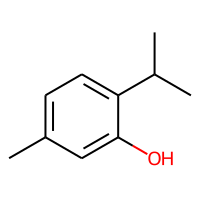
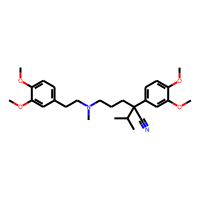
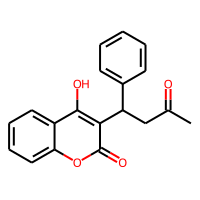

In [15]:
desc_cols = ['MW','LogP','NumAromatic','HBond_Donor','HBond_Acceptor','Rot_Bond', 'Hev_Atm']
df2[desc_cols] = df2.desc.to_list()
df2.drop(["desc","InChIKey"],axis=1,inplace=True)
df2

Plot solubility as a sanity check

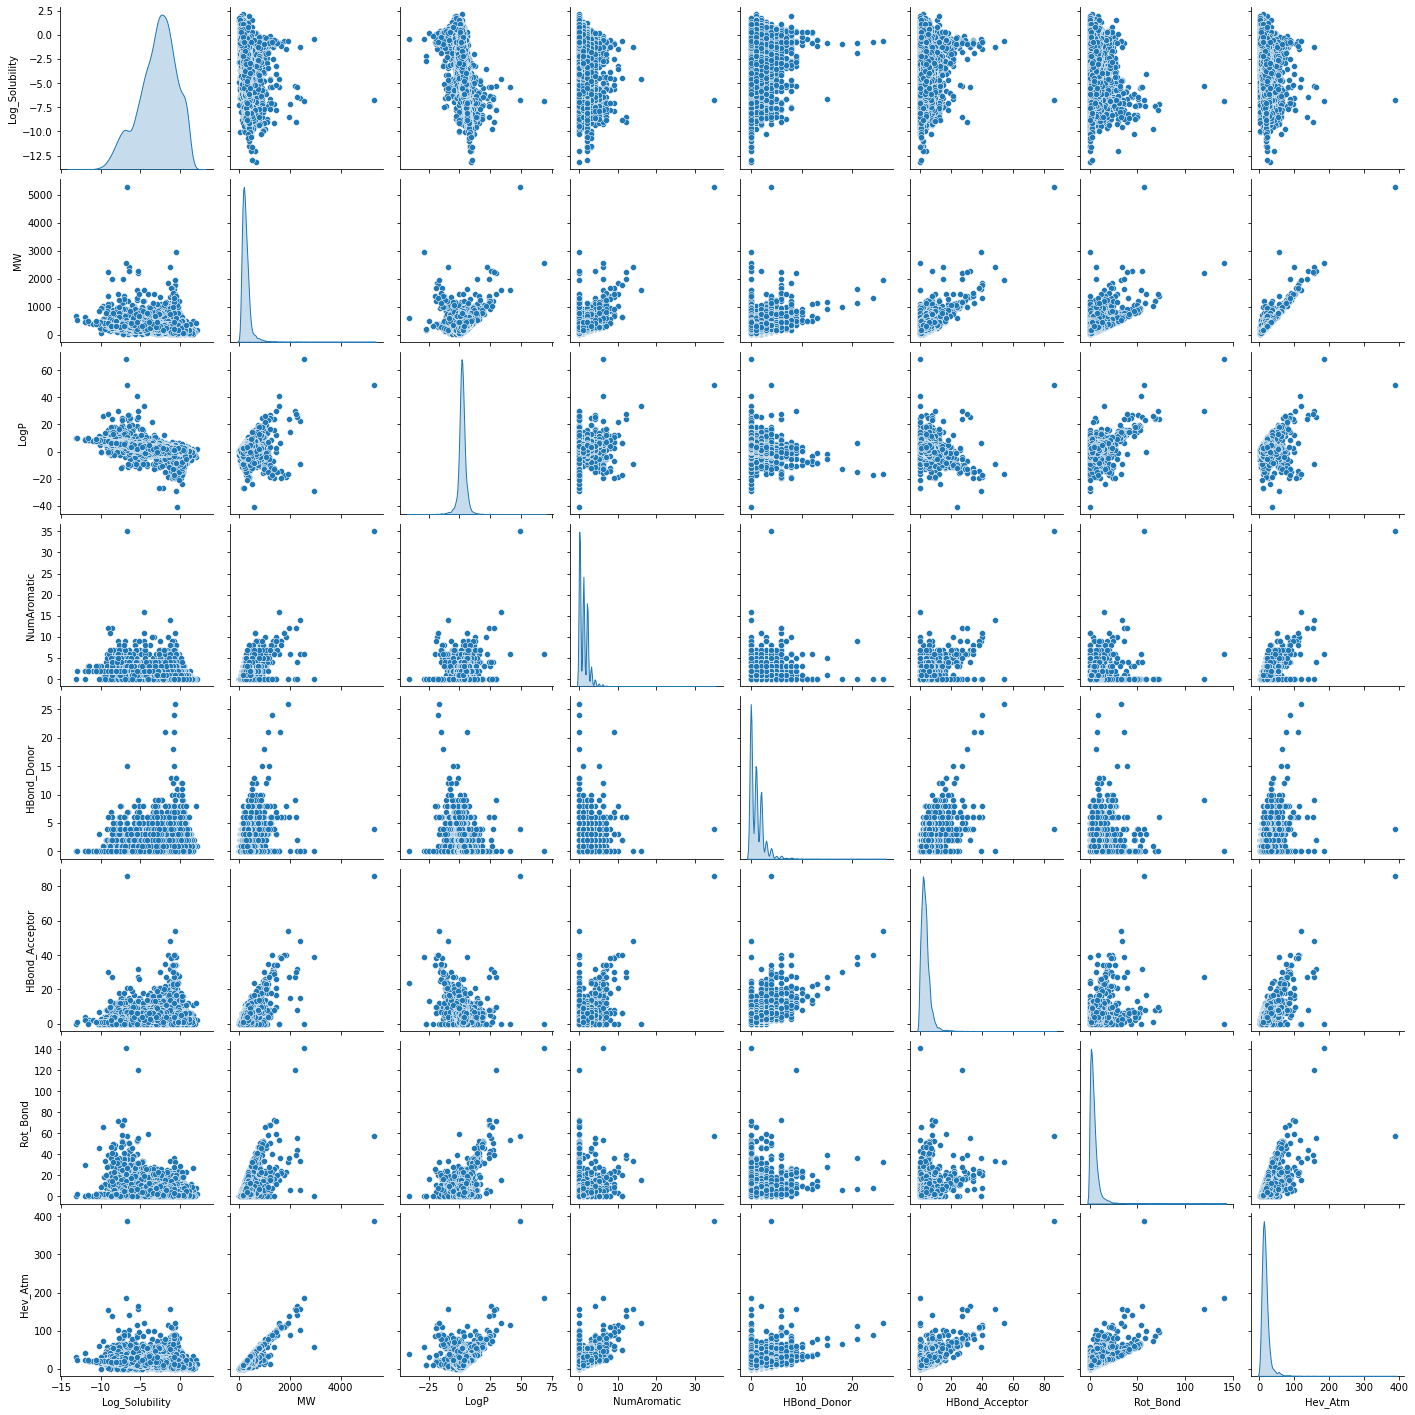

In [16]:
sns.pairplot(df2[['Log_Solubility', 'MW', 'LogP', 'NumAromatic','HBond_Donor','HBond_Acceptor','Rot_Bond', 'Hev_Atm']], diag_kind='kde')

In [17]:
df2[['Log_Solubility', 'MW', 'LogP', 'NumAromatic','HBond_Donor','HBond_Acceptor','Rot_Bond', 'Hev_Atm']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Log_Solubility,9982.0,-2.889909,2.368154,-13.1719,-4.326325,-2.618173,-1.209735,2.137682
MW,9982.0,266.665946,184.179024,9.0120,162.276000,228.682000,320.436000,5299.456000
LogP,9982.0,1.979940,3.518775,-40.8732,0.619750,1.949220,3.422840,68.541140
NumAromatic,9982.0,1.066119,1.299247,0.0000,0.000000,1.000000,2.000000,35.000000
HBond_Donor,9982.0,1.108595,1.488973,0.0000,0.000000,1.000000,2.000000,26.000000
HBond_Acceptor,9982.0,3.485674,3.497597,0.0000,2.000000,3.000000,4.000000,86.000000
Rot_Bond,9982.0,4.073031,5.646925,0.0000,1.000000,3.000000,5.000000,141.000000
Hev_Atm,9982.0,17.374674,12.241536,1.0000,11.000000,15.000000,21.000000,388.000000


## Possibility of searching for moities

In [20]:
query = Chem.MolFromSmarts("c1ccccn1")

In [21]:
df2['pyridine'] = [x.HasSubstructMatch(query) for x in tqdm(df2.Structure)]

100%|██████████| 9982/9982 [00:00<00:00, 74498.86it/s]


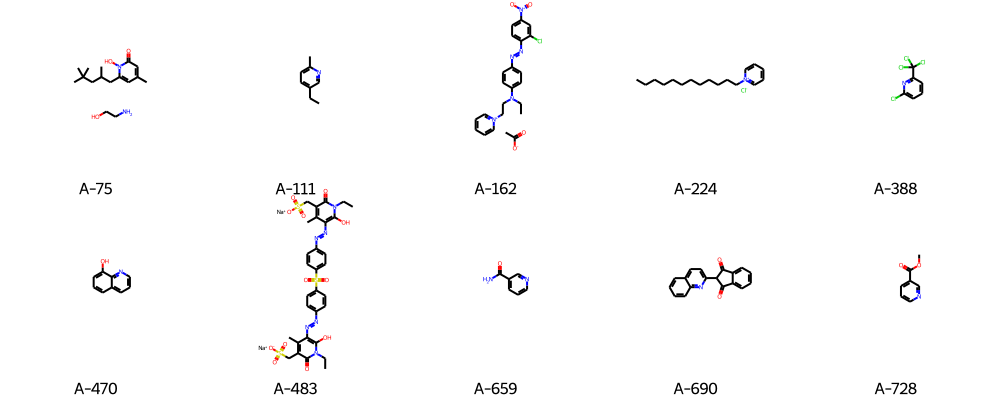

In [22]:
hits = df2.query("pyridine").head(10)
MolsToGridImage(hits.Structure,legends=hits.ID.to_list(),molsPerRow=5)

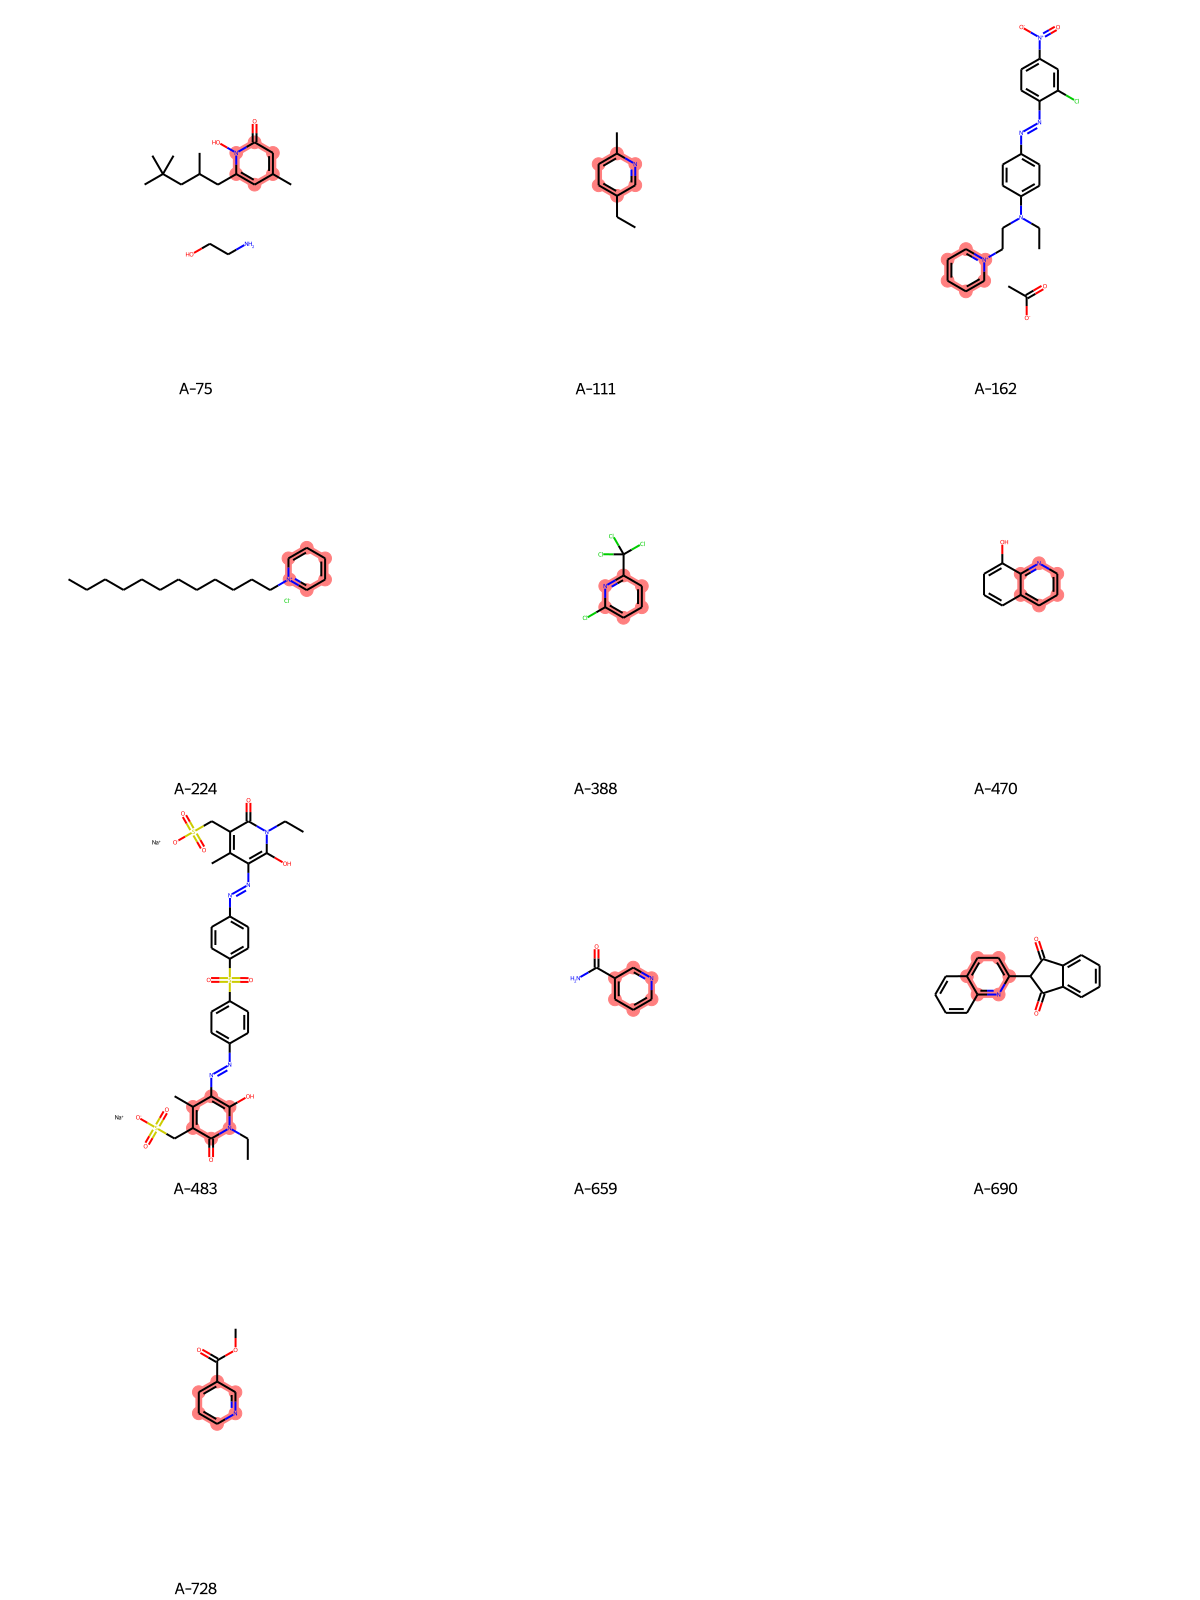

In [23]:
match_list = [x.GetSubstructMatch(query) for x in hits.Structure]
MolsToGridImage(hits.Structure,legends=hits.ID.to_list(),molsPerRow=3,highlightAtomLists=match_list,subImgSize=(400, 400))

# Neural Networks

In [26]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing

In [27]:
X=df2[['MW','LogP','NumAromatic','HBond_Donor','HBond_Acceptor', 'Rot_Bond', 'Hev_Atm']]
y=df2[['Log_Solubility']]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

In [29]:
print('X_train.shape',X_train.shape)
print('X_test.shape',X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

X_train.shape (7985, 7)
X_test.shape (1997, 7)
y_train.shape (7985, 1)
y_test.shape (1997, 1)


The Normalization layer

In [167]:
#normalizer = preprocessing.Normalization(axis=-1)
#normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)

In [168]:
# Adaptation of normalization to training data
#normalizer.adapt(np.array(X_train))

## Defining a deep neural network model

https://github.com/bnsreenu/python_for_microscopists/blob/master/141-regression_housing_example.py

In [30]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# define the model
#Experiment with deeper and wider networks
model = Sequential()
model.add(Dense(128, input_dim=7, activation='sigmoid'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='sigmoid'))
#Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs =100)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 13,505
Trainable params: 13,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
200/200 [==============================] - 1s 5ms/step - loss: 4.1735 - mae: 1.5574 - val_loss: 2.7015 - val_mae: 1.2118
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 2.3042 - mae: 1.1280 - val_loss: 2.3867 

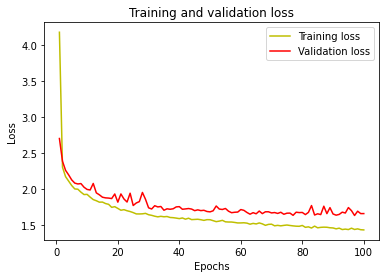

In [50]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

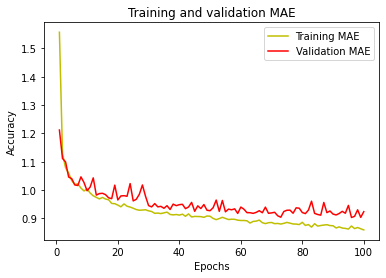

In [51]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
#Predict on test data
predictions = model.predict(X_test_scaled)

Text(0.5, 0, 'True Values [Log_Solubility]')

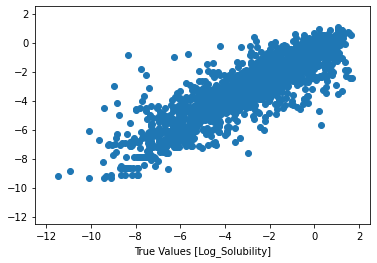

In [63]:
#a = plt.axes(aspect='equal')
plt.scatter(y_test, predictions)
plt.xlim([-12.5, 2.5])
plt.ylim([-12.5, 2.5])
plt.xlabel('True Values [Log_Solubility]')


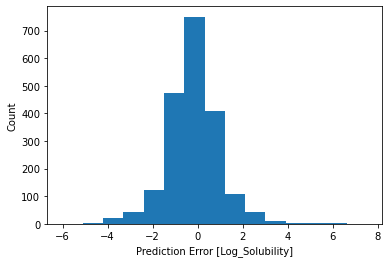

In [59]:
err = predictions.reshape(-1,1) - y_test
plt.hist(err, bins=15)
plt.xlabel('Prediction Error [Log_Solubility]')
_ = plt.ylabel('Count')